In [17]:
curr_dir = '/home/vayzenbe/GitHub_Repos/ginn'

import sys
sys.path.insert(1, f'{curr_dir}/Models')
import os, argparse
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageOps,  ImageFilter
from itertools import chain
import pandas as pd
import numpy as np
import seaborn as sns
import cornet
import model_funcs
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline
import LoadFrames
from scipy import stats, spatial

In [18]:
im_dir = "/home/vayzenbe/GitHub_Repos/ginn/Stim/exp_stim"
im_dir = '/home/vayzenbe/matlab_toolboxes/SHINEtoolbox/SHINEtoolbox/SHINE_OUTPUT'
final_dir = "/home/vayzenbe/GitHub_Repos/ginn/Stim/gray_exp_stim"

weights_dir = f"/lab_data/behrmannlab/vlad/ginn/model_weights"


train_cond = ['imagenet_objects','vggface']
n_classes = [600, 600]

model_epoch = 15

model_type = 'classify'
layer = 'aIT'

im_count = 15 #how many ims to test at a time
iters = 10000 #how many times to search through the data


transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])

cos = nn.CosineSimilarity(dim=0, eps=1e-6)


In [19]:
def load_files(dirName):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
            
    return listOfFiles    

In [20]:
def extract_acts(model, im):
    """
    Extracts the activations for a series of images
    """
    model.eval()

    with torch.no_grad():

        im = im.cuda()
        output = model(im)
        output =output.view(output.size(0), -1)
        

    return output, label

In [21]:
def create_cos_rdm(output):
    """calculate cos similarity between each image"""
    rdm =[]
    for ii in range(0,len(output)):
        for kk in range(ii+1,len(output)):
            sim = cos(output[ii], output[kk])
            sim =sim.cpu().numpy()
            rdm.append(sim)

    return rdm

In [22]:
def image_loader(image_name):
    #make image grayscale
    image_name = ImageOps.grayscale(image_name).convert("RGB")
    #image_name = image_name.filter(ImageFilter.GaussianBlur(radius=4))
    """load image, returns cuda tensor"""
    image_name = transform(image_name).unsqueeze(0)
    #image_name = Variable(normalize(to_tensor(scaler(image_name))).unsqueeze(0))
    image_name.cuda()
    return image_name


In [ ]:
dataset = LoadFrames.LoadFrames(im_dir,  transform=transform)
#load first model
model1 = model_funcs.load_model(model_type, train_cond[0], model_epoch, weights_dir, n_classes[0])
model1 =  model_funcs.remove_layer(model1, layer)

#load second model
model2 = model_funcs.load_model(model_type, train_cond[1], model_epoch, weights_dir, n_classes[1])
model2 =  model_funcs.remove_layer(model2, layer)

#loop through iterations
for ii in range(0,iters):


    loader = torch.utils.data.DataLoader(dataset, batch_size=im_count, shuffle=True, drop_last = True,num_workers = 4, pin_memory=True)
    im, label = next(iter(loader))

    out1, label1 = extract_acts(model1,im)
    out2, label2 = extract_acts(model2,im)

    rdm1 = create_cos_rdm(out1)
    rdm2 = create_cos_rdm(out2)

    corr = np.corrcoef(rdm1, rdm2)
    if ii == 0:
        best_corr = corr[0,1]
    else:
        new_corr = corr[0,1]

        if new_corr < best_corr:
            best_ims = label1
            best_corr = new_corr
    

df = pd.DataFrame(best_ims)
df.to_csv('best_ims.csv')






Traceback (most recent call last):


In [ ]:
'''
Copy best IMs to experiment folder
'''

from shutil import copyfile

df = pd.read_csv('best_ims.csv')
df['0']

for ii in df['0']:
    
    im_file = f'{im_dir}/{ii}'
    
    copyfile(im_file, f'{final_dir}/{ii}')


In [24]:
'''
Reload best ims to calculate final correlation and generate figures
'''

dataset = LoadFrames.LoadFrames(final_dir,  transform=transform)
#load first model
model1 = model_funcs.load_model(model_type, train_cond[0], model_epoch, weights_dir, n_classes[0])
model1 =  model_funcs.remove_layer(model1, layer)

#load second model
model2 = model_funcs.load_model(model_type, train_cond[1], model_epoch, weights_dir, n_classes[1])
model2 =  model_funcs.remove_layer(model2, layer)

#loop through iterations



loader = torch.utils.data.DataLoader(dataset, batch_size=im_count, shuffle=True, drop_last = True,num_workers = 4, pin_memory=True)
im, label = next(iter(loader))

out1, label1 = extract_acts(model1,im)
out2, label2 = extract_acts(model2,im)

rdm1 = create_cos_rdm(out1)
rdm2 = create_cos_rdm(out2)

corr = np.corrcoef(rdm1, rdm2)

print(corr)

sym_rdm1 = spatial.distance.squareform(rdm1, checks = True)
sym_rdm2 = spatial.distance.squareform(rdm2, checks = True)

new_rdm1 = pd.Series(rdm1)
new_rdm2 = pd.Series(rdm2)

comb_rdm = pd.concat([new_rdm1, new_rdm2], axis=1)
comb_rdm = comb_rdm.rename(columns={0: "General", 1: "Face"})

[[1.         0.08942302]
 [0.08942302 1.        ]]


/home/vayzenbe/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vayzenbe/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Face Model'}, ylabel='Density'>

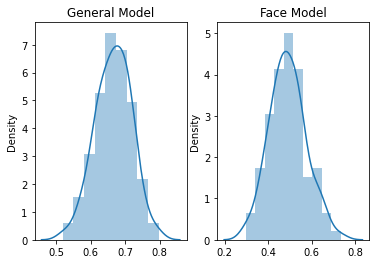

In [25]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title('General Model')
axes[1].set_title('Face Model')
sns.distplot(new_rdm1, ax=axes[0])
sns.distplot(new_rdm2, ax=axes[1])


/home/vayzenbe/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


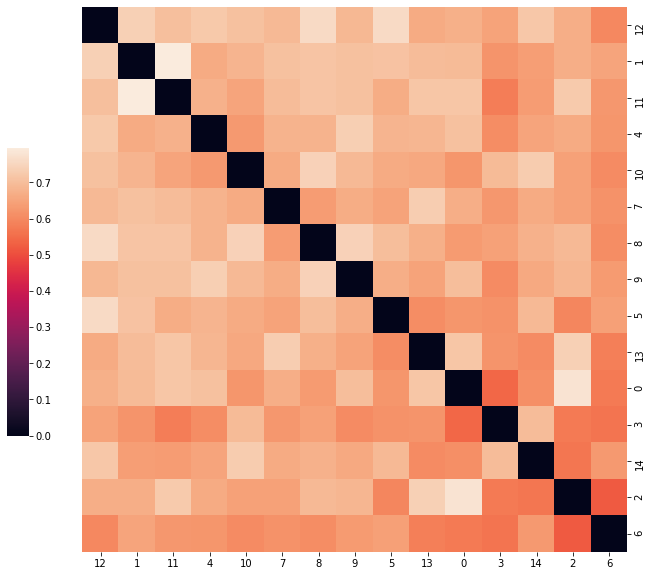

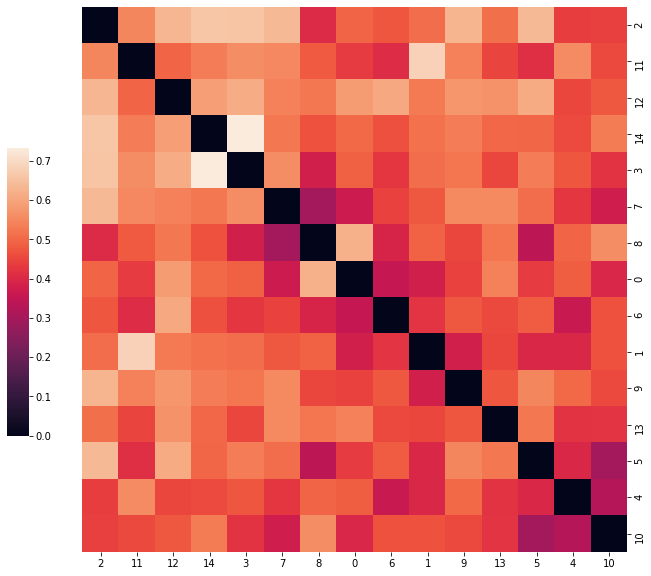

In [26]:
map1 =sns.clustermap(sym_rdm1,cbar_pos=(0.1, .2, .03, .4))

map1.ax_row_dendrogram.set_visible(False)
map1.ax_col_dendrogram.set_visible(False)

map2 =sns.clustermap(sym_rdm2,cbar_pos=(0.1, .2, .03, .4))

map2.ax_row_dendrogram.set_visible(False)
map2.ax_col_dendrogram.set_visible(False)

In [12]:
df = pd.read_csv('best_ims.csv')

In [21]:
exp_trials =[]
for im1n, im1 in enumerate(df.iloc[:,1].tolist()):
    for im2n, im2 in enumerate(df.iloc[im1n:,1].tolist()):
        exp_trials.append([im1,im2])
        
        

In [22]:
len(exp_trials)

120

In [27]:
final_trials = np.asarray(exp_trials)
final_trials
np.savetxt('exp_trials.csv', final_trials, fmt='%s', delimiter=',') 